In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from qutip import *
from scipy import constants
import scipy
from sympy.physics.wigner import wigner_6j
from sympy.physics.quantum.cg import CG

In [2]:
def gaussian(t, tau, sigma):
    a = np.exp(-0.5 * ((-tau / 2) / sigma)**2)
    return (np.exp(-0.5 * ((t - tau / 2) / sigma)**2) - a) / (1 - a)

def gaussian_flat_top(t, t0, tau, rise_time, k=3):
    sigma = rise_time / k
    flat_time = tau - 2 * rise_time
    
    # Compute sections with vectorized operations
    a = np.exp(-0.5 * ((-rise_time) / sigma) ** 2)
    ring_up = (np.exp(-0.5 * (((t - t0) - rise_time) / sigma) ** 2) - a) / (1 - a)
    ring_down = (np.exp(-0.5 * ((rise_time + flat_time - (t - t0)) / sigma) ** 2) - a) / (1 - a)

    # Create a mask for different regions
    ring_up_mask = (t0 <= t) & (t <= t0 + rise_time)
    flat_mask = (t > t0 + rise_time) & (t < t0 + rise_time + flat_time)
    ring_down_mask = (t >= t0 + rise_time + flat_time) & (t <= t0 + tau)

    # Initialize output array
    result = np.zeros_like(t)

    # Assign values based on masks
    result[ring_up_mask] = ring_up[ring_up_mask]
    result[flat_mask] = 1
    result[ring_down_mask] = ring_down[ring_down_mask]

    return result

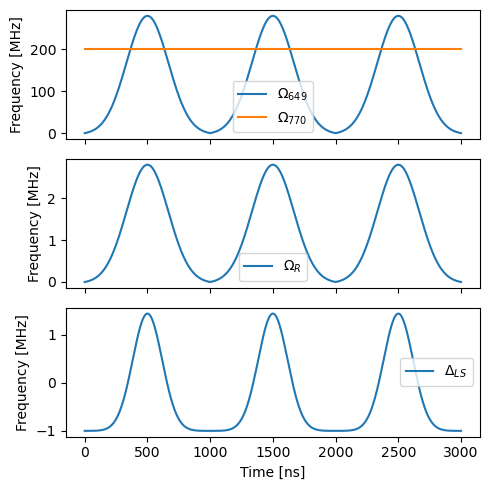

In [3]:
Omega_Raman = 2 * np.pi * 2.8 * 1e6
Omega_770 = 2 * np.pi * 200 * 1e6
detuning = 2 * np.pi * 10 * 1e9
Omega_649 = Omega_Raman / (Omega_770 / (2 * detuning))
num_pulses = 3
num_steps = 1000 
rise_time = 500e-9 
gate_time = 1000e-9 
freq_scale = 1e9


ts = np.linspace(0, num_pulses * gate_time * freq_scale, num_steps)
pulse = np.zeros_like(ts)
for i in range(num_pulses):
    pulse += gaussian_flat_top(ts, ts[i * num_steps // num_pulses], gate_time * freq_scale, rise_time * freq_scale, k=3)

def Omega_649_arr(t):
    return np.interp(t, ts, pulse) * Omega_649

def Omega_Raman_arr(t):
    return Omega_649_arr(t) * Omega_770 / (2 * detuning)

def light_shift_arr(t):
    shift_649 = Omega_649_arr(t)**2 / (4 * detuning) + (Omega_649_arr(t) * 0.660000 / 0.933)**2 / (4 * (detuning + 2 * np.pi * 10.22 * 1e9))
    shift_770 = Omega_770**2 / (4 * detuning)
    return (shift_649 - shift_770) / freq_scale


%matplotlib inline

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(5, 5), sharex=True)

ax[0].plot(ts, Omega_649_arr(ts) / 2 / np.pi / 1e6, label=r'$\Omega_{649}$')
ax[0].plot(ts, Omega_770 * np.ones_like(Omega_649_arr(ts)) / 2 / np.pi / 1e6, label=r'$\Omega_{770}$')
ax[0].set_ylabel('Frequency [MHz]')
ax[0].legend()

ax[1].plot(ts, Omega_Raman_arr(ts) / 2 / np.pi / 1e6, label=r'$\Omega_R$')
ax[1].set_ylabel('Frequency [MHz]')
ax[1].legend()

ax[2].plot(ts, light_shift_arr(ts) / 2 / np.pi * 1e3, label=r'$\Delta_{LS}$')
ax[2].set_ylabel('Frequency [MHz]')
ax[2].legend()

ax[2].set_xlabel('Time [ns]')


fig.tight_layout()


In [211]:
def simulate_raman_gate(
    Omega_649: float,
    Omega_770: float,
    detuning: float,
    gate_time: float,
    rise_time: float,
    num_pulses: int,
    num_points: int,
    initial_states: list[str],
    detuning_offset: float = 0,
    rise_sigma: float = 3,
):
    
    
    freq_scale = 1e9  # GHz
    
    # =========================
    # Initialize energy levels 
    # =========================
    # NOTE: hard-coded for 5G magnetic field
    
    levels = [
        # 3P0 sublevels
        {'level': '3P0', 'J': 0, 'F': 1/2, 'mF': 1/2,  'energy_Hz': 0},
        {'level': '3P0', 'J': 0, 'F': 1/2, 'mF': -1/2, 'energy_Hz': 3749.528976851414},
        # 3S1 sublevels
        {'level': '3S1', 'J': 1, 'F': 1/2, 'mF': 1/2,  'energy_Hz': 461850274160685.7},
        {'level': '3S1', 'J': 1, 'F': 1/2, 'mF': -1/2, 'energy_Hz': 461850292913971.44},
        {'level': '3S1', 'J': 1, 'F': 3/2, 'mF': 3/2,  'energy_Hz': 461860484233885.6},
        {'level': '3S1', 'J': 1, 'F': 3/2, 'mF': 1/2,  'energy_Hz': 461860493612403.4},
        {'level': '3S1', 'J': 1, 'F': 3/2, 'mF': -1/2, 'energy_Hz': 461860502990920.8},
        {'level': '3S1', 'J': 1, 'F': 3/2, 'mF': -3/2, 'energy_Hz': 461860512369438.56},
        # 3P2 sublevels
        {'level': '3P2', 'J': 2, 'F': 3/2, 'mF': 3/2,  'energy_Hz': 72602523903671.75},
        {'level': '3P2', 'J': 2, 'F': 3/2, 'mF': 1/2,  'energy_Hz': 72602536499251.66},
        {'level': '3P2', 'J': 2, 'F': 3/2, 'mF': -1/2, 'energy_Hz': 72602549094831.69},
        {'level': '3P2', 'J': 2, 'F': 3/2, 'mF': -3/2, 'energy_Hz': 72602561690411.6},
        {'level': '3P2', 'J': 2, 'F': 5/2, 'mF': 5/2,  'energy_Hz': 72609214146883.69},
        {'level': '3P2', 'J': 2, 'F': 5/2, 'mF': 3/2,  'energy_Hz': 72609222545186.78},
        {'level': '3P2', 'J': 2, 'F': 5/2, 'mF': 1/2,  'energy_Hz': 72609230943489.86},
        {'level': '3P2', 'J': 2, 'F': 5/2, 'mF': -1/2, 'energy_Hz': 72609239341793.05},
        {'level': '3P2', 'J': 2, 'F': 5/2, 'mF': -3/2, 'energy_Hz': 72609247740096.14},
        {'level': '3P2', 'J': 2, 'F': 5/2, 'mF': -5/2, 'energy_Hz': 72609256138399.22},
    ]

    N = len(levels) + 1  # include extra state to model 3S1 -> 3P1 decay
    basis_states = []
    for i, level in enumerate(levels):
        new_row = level.copy()
        new_row['basis'] = basis(N, i)
        basis_states.append(new_row)
    basis_states = pd.DataFrame(basis_states)
    
    # set intermediate and excited states for Raman gate
    reference_state_3s1 = basis_states[(basis_states['level'] == '3S1') & \
                                       (basis_states['F'] == 3/2) & \
                                       (basis_states['mF'] == 1/2)]
    reference_state_3p2 = basis_states[(basis_states['level'] == '3P2') & \
                                       (basis_states['F'] == 5/2) & \
                                       (basis_states['mF'] == 1/2)]
        
    # ==============================
    # matrix elements [atomic units]
    # ==============================
    
    # level1 = 3P0 -> level2 = 3S1
    matrix_elements_649 = [
        {'F1': 1/2, 'F2': 1/2, 'mF1': 1/2, 'mF2': 1/2, 'matrix_element': 0.660000},
        {'F1': 1/2, 'F2': 1/2, 'mF1': -1/2, 'mF2': -1/2, 'matrix_element': -0.660000},
        {'F1': 1/2, 'F2': 3/2, 'mF1': 1/2, 'mF2': 1/2, 'matrix_element': -0.933381},
        {'F1': 1/2, 'F2': 3/2, 'mF1': -1/2, 'mF2': -1/2, 'matrix_element': -0.933381},
    ]
    # level1 = 3P2 -> level2 = 3S1 
    matrix_elements_770 = [
        {'F1': 3/2, 'F2': 1/2, 'mF1': 1/2, 'mF2': 1/2, 'matrix_element': 1.683333},
        {'F1': 3/2, 'F2': 1/2, 'mF1': -1/2, 'mF2': -1/2, 'matrix_element': 1.683333},
        {'F1': 3/2, 'F2': 3/2, 'mF1': 3/2, 'mF2': 3/2, 'matrix_element': -0.714178},
        {'F1': 3/2, 'F2': 3/2, 'mF1': 1/2, 'mF2': 1/2, 'matrix_element': -0.238059},
        {'F1': 3/2, 'F2': 3/2, 'mF1': -1/2, 'mF2': -1/2, 'matrix_element': 0.238059},
        {'F1': 3/2, 'F2': 3/2, 'mF1': -3/2, 'mF2': -3/2, 'matrix_element': 0.714178},
        {'F1': 5/2, 'F2': 3/2, 'mF1': 3/2, 'mF2': 3/2, 'matrix_element': 1.428356},
        {'F1': 5/2, 'F2': 3/2, 'mF1': 1/2, 'mF2': 1/2, 'matrix_element': 1.749371},
        {'F1': 5/2, 'F2': 3/2, 'mF1': -1/2, 'mF2': -1/2, 'matrix_element': 1.749371},
        {'F1': 5/2, 'F2': 3/2, 'mF1': -3/2, 'mF2': -3/2, 'matrix_element': 1.428356},
    ]
    
    reference_matrix_element_649 = -0.933381
    reference_matrix_element_770 = 1.749371
    # compute Rabi frequencies [Hz] for each transition
    rabi_frequencies_649 = []
    for row in matrix_elements_649:
        # copy row and remove matrix element
        new_row = row.copy()
        new_row.pop('matrix_element')
        # compute rabi frequency
        matrix_element = row['matrix_element']
        new_row['rabi_frequency'] = matrix_element / reference_matrix_element_649
        rabi_frequencies_649.append(new_row)
    # compute Rabi frequencies [Hz] for each transition
    rabi_frequencies_770 = []
    for row in matrix_elements_770:
        # copy row and remove matrix element
        new_row = row.copy()
        new_row.pop('matrix_element')
        # compute rabi frequency
        matrix_element = row['matrix_element']
        new_row['rabi_frequency'] = Omega_770 * matrix_element / reference_matrix_element_770
        rabi_frequencies_770.append(new_row)
        
    # =====================
    # Construct Hamiltonian
    # =====================
    
    # Initialize Hamiltonian
    H0 = 0
    H1 = 0
    H2 = 0

    # 3P0 -> 3S1
    for transition in rabi_frequencies_649:
        Omega = transition['rabi_frequency'] / freq_scale
        state1 = basis_states[(basis_states['level'] == '3P0') & \
                            (basis_states['F'] == transition['F1']) & \
                            (basis_states['mF'] == transition['mF1'])]
        state2 = basis_states[(basis_states['level'] == '3S1') & \
                            (basis_states['F'] == transition['F2']) & \
                            (basis_states['mF'] == transition['mF2'])]
        # add coupling term
        basis1 = state1['basis'].values[0]
        basis2 = state2['basis'].values[0]
        coupling_term = (Omega / 2) * (basis1 * basis2.dag() + basis2 * basis1.dag())
        H1 += coupling_term
        
    # 3S1 -> 3P2
    for transition in rabi_frequencies_770:
        Omega = transition['rabi_frequency'] / freq_scale
        state1 = basis_states[(basis_states['level'] == '3P2') & \
                            (basis_states['F'] == transition['F1']) & \
                            (basis_states['mF'] == transition['mF1'])]
        state2 = basis_states[(basis_states['level'] == '3S1') & \
                            (basis_states['F'] == transition['F2']) & \
                            (basis_states['mF'] == transition['mF2'])]
        # add coupling term
        basis1 = state1['basis'].values[0]
        basis2 = state2['basis'].values[0]
        coupling_term = (Omega / 2) * (basis1 * basis2.dag() + basis2 * basis1.dag())
        H0 += coupling_term
        
    # add detunings
    for state in basis_states.to_records():
        if state['level'] in ['3P0', '3P2']:
            H0 += (detuning / freq_scale) * state['basis'] * state['basis'].dag()
        if state['level'] == '3S1':
            ref_detuning = (state['energy_Hz'] - reference_state_3s1['energy_Hz'].values[0]) / freq_scale
            H0 += 2 * np.pi * ref_detuning * state['basis'] * state['basis'].dag()
        if state['level'] == '3P2':
            ref_detuning = (state['energy_Hz'] - reference_state_3p2['energy_Hz'].values[0]) / freq_scale
            H0 += 2 * np.pi * ref_detuning * state['basis'] * state['basis'].dag()
            # detune 770 halfway between mF = -1/2 and mF = 1/2 sublevels
            H0 -= 2 * np.pi * 4.19915159375 * 1e6 / freq_scale * state['basis'] * state['basis'].dag()
            # add constant detuning offset
            H0 += (detuning_offset / freq_scale) * state['basis'] * state['basis'].dag()
    for state in basis_states.to_records():
        if state['level'] == '3P2':
            H2 += state['basis'] * state['basis'].dag() / freq_scale
    
    # Time vector
    t_max = num_pulses * gate_time * freq_scale    
    t_list = np.linspace(0, t_max, num_points)
    
    # Control pulse
    pulse = np.zeros_like(t_list)
    for i in range(num_pulses):
        pulse += gaussian_flat_top(
            t_list, 
            t_list[i * num_points // num_pulses], 
            gate_time * freq_scale, 
            rise_time * freq_scale, 
            k=rise_sigma)
    
    # Time-dependent Hamiltonian coefficients
    def Omega_649_arr(t):
        return Omega_649 * np.interp(t, t_list, pulse)
    def light_shift_arr(t):
        shift_649 = Omega_649_arr(t)**2 / (4 * detuning) + (Omega_649_arr(t) * 0.660000 / 0.933)**2 / (4 * (detuning + 2 * np.pi * 10.22 * 1e9))
        shift_770 = Omega_770**2 / (4 * detuning)
        return (shift_649 - shift_770)
    
        
    # ============================
    # Construct collapse operators
    # ============================
    
    I = 1/2
    levels_3s1 = basis_states[(basis_states['level'] == '3S1')].to_records()
    levels_3p2 = basis_states[(basis_states['level'] == '3P2')].to_records()
    levels_3p0 = basis_states[(basis_states['level'] == '3P0')].to_records()
    decay_rate_3s1 = 2 * np.pi * 10.01 * 1e6 / freq_scale
    branching_ratios = {'3P2': 0.5, '3P1': 0.37, '3P0': 0.13}
    
    def calculate_c_op(level_g, level_e):
        F_e = level_e['F']
        F_g = level_g['F']
        mF_e = level_e['mF']
        mF_g = level_g['mF']
        J_e = level_e['J']
        J_g = level_g['J']
        basis_e = level_e['basis']
        basis_g = level_g['basis']
        return (-1)**(F_e + J_g + 1 + I) * \
                np.sqrt((2 * F_e + 1) * (2 * J_g + 1)) * \
                CG(F_e, mF_e, 1, q, F_g, mF_g).doit() * \
                float(wigner_6j(J_e, J_g, 1, F_g, F_e, I)) * \
                basis_g * basis_e.dag()
    
    c_ops_3p2 = []
    c_ops_3p0 = []
    for q in [-1, 0, 1]:
        c_op_3p2 = 0
        c_op_3p0 = 0
        for level_3s1 in levels_3s1:
            for level_3p2 in levels_3p2:
                c_op_3p2 += calculate_c_op(level_3p2, level_3s1)
            for level_3p0 in levels_3p0:
                c_op_3p0 += calculate_c_op(level_3p0, level_3s1)
        c_op_3p2 *= np.sqrt(decay_rate_3s1 * branching_ratios['3P2'])
        c_op_3p0 *= np.sqrt(decay_rate_3s1 * branching_ratios['3P0'])
        c_ops_3p2.append(c_op_3p2)
        c_ops_3p0.append(c_op_3p0)
    c_op_3p1 = 0
    basis_3p1 = basis(N, N-1)
    for level_3s1 in levels_3s1:
        c_op_3p1 += basis_3p1 * level_3s1['basis'].dag() 
    c_op_3p1 *= np.sqrt(decay_rate_3s1 * branching_ratios['3P1'])
    c_ops = c_ops_3p0 + c_ops_3p2 + [c_op_3p1]
    
    # =======================
    # Simulate time evolution
    # =======================
    
    qubit_basis_0 = basis_states[(basis_states['level'] == '3P0') & \
                                 (basis_states['F'] == 1/2) & \
                                 (basis_states['mF'] == -1/2)]['basis'].values[0]
    qubit_basis_1 = basis_states[(basis_states['level'] == '3P0') & \
                                 (basis_states['F'] == 1/2) & \
                                 (basis_states['mF'] == 1/2)]['basis'].values[0]

    rho_inital_dict = {
        '00': qubit_basis_0 * qubit_basis_0.dag(), 
        '01': qubit_basis_0 * qubit_basis_1.dag(), 
        '10': qubit_basis_1 * qubit_basis_0.dag(), 
        '11': qubit_basis_1 * qubit_basis_1.dag()
    }

    # Expectation operators
    e_ops = None #[state['basis'] * state['basis'].dag() for state in basis_states.to_records()]

    # Solve for the time evolution
    result_dict = {}
    for state in initial_states:
        result = mesolve(
            [H0, [H1, Omega_649_arr], [H2, light_shift_arr]], 
            rho_inital_dict[state], 
            t_list, 
            e_ops=e_ops, 
            c_ops=c_ops,
            options=dict(store_states=True))
        result_dict[state] = result
        
    # Construct return value
    output = {
        'basis_states': basis_states,
        't_list': t_list,
        'results': result_dict
    }
        
    return output

In [301]:
import pickle
with open('data/20250204_rise_time_vs_infidelity_sweep.pkl', 'rb') as f:
    data = pickle.load(f)
    
idx = np.argmin(data['optimal_infidelities'][1])
Omega = data['optimal_Omegas'][1][idx]
infidelity = data['optimal_infidelities'][1][idx]
print(data['rise_sigmas'][idx])
print(Omega / 2 / np.pi)
print(infidelity)

2.7894736842105265
2.6494628099173556
2.0530926270190264e-06


In [302]:
Omega_Raman = 2 * np.pi * 2.6494628099173556 * 1e6
Deltas = 2 * np.pi * np.array([25, 50, 75, 100, 150, 200, 300, 400, 500]) * 1e9
Omega_649 = np.sqrt(Omega_Raman * (2 * Deltas))
Omega_770 = Omega_649
num_pulses = 2
gate_time = 1e-6
rise_time = 0.5e-6
rise_sigma = 2.7894736842105265
# num_points = num_pulses * 2000 
detuning_offset = 0
initial_states = ['00', '01', '10', '11']

outputs = []
for i, Delta in enumerate(Deltas):
    if (Delta / 2 / np.pi / 1e9) > 200:
        num_points = num_pulses * 2000
    else:
        num_points = num_pulses * 1000
    output = simulate_raman_gate(
        Omega_649=Omega_649[i],
        Omega_770=Omega_770[i],
        detuning=Delta,
        gate_time=gate_time,
        rise_time=rise_time,
        num_pulses=num_pulses,
        num_points=num_points,
        detuning_offset=detuning_offset,
        rise_sigma=rise_sigma,
        initial_states=initial_states)
    outputs.append(output)

In [234]:
%matplotlib inline

basis_states = output['basis_states']
results = output['results']

ground_0_idx = [i for i, state in enumerate(basis_states.to_records()) \
    if state['level'] == '3P0' and state['F'] == 0.5 and state['mF'] == -0.5][0]
ground_1_idx = [i for i, state in enumerate(basis_states.to_records()) \
    if state['level'] == '3P0' and state['F'] == 0.5 and state['mF'] == 0.5][0]

intermediate_0_idx = [i for i, state in enumerate(basis_states.to_records()) \
    if state['level'] == '3S1' and state['F'] == 1.5 and state['mF'] == -0.5][0]
intermediate_1_idx = [i for i, state in enumerate(basis_states.to_records()) \
    if state['level'] == '3S1' and state['F'] == 1.5 and state['mF'] == 0.5][0]

excited_0_idx = [i for i, state in enumerate(basis_states.to_records()) \
    if state['level'] == '3P2' and state['F'] == 2.5 and state['mF'] == -0.5][0]
excited_1_idx = [i for i, state in enumerate(basis_states.to_records()) \
    if state['level'] == '3P2' and state['F'] == 2.5 and state['mF'] == 0.5][0]


ts = output['t_list']
ys_0 = results['00'].expect[ground_0_idx]
ys_1 = results['11'].expect[ground_1_idx]

fig, ax = plt.subplots(ncols=2, sharex=True, figsize=(10, 3))

ax[0].plot(ts, ys_0)
ax[1].plot(ts, ys_1)


ax[0].set_xlabel('Time [ns]')
ax[1].set_xlabel('Time [ns]')
ax[0].set_title(r'$|0\rangle$ population')
ax[1].set_title(r'$|1\rangle$ population')

IndexError: list index out of range

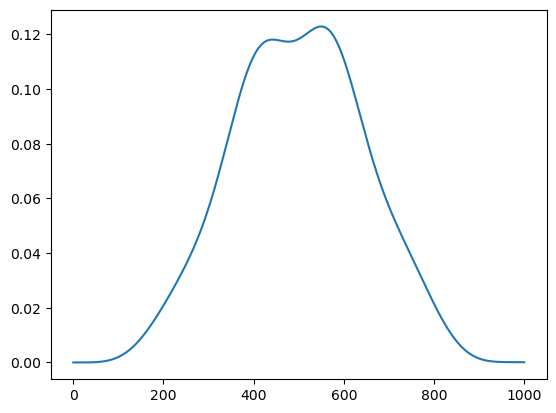

In [205]:
plt.figure()

plt.plot(ts, results['11'].expect[excited_1_idx])

In [303]:
def calculate_fidelity(actual_superop: Qobj, ideal_superop: Qobj):
    vec = np.array(actual_superop[:,:]) @ np.array([1, 0, 0, 1])
    arr = Qobj(np.array([[vec[0], vec[1]], [vec[2], vec[3]]]))
    leakage = 1 - (arr.tr() / 2)
    process_fidelity = 1/4 * Qobj(ideal_superop.dag()[:,:] @ actual_superop[:,:]).tr()
    return np.real((2 * process_fidelity + 1 - leakage) / 3)


for output, Delta in zip(outputs, Deltas):
    
    results = output['results']
    
    rho_final = {state: result.states[-1] for state, result in results.items()}
    subspace_vector_final = {state: operator_to_vector(Qobj(rho[:2,:2]))[::-1,:] for state, rho in rho_final.items()}

    super_op_sim = Qobj(np.column_stack((
        subspace_vector_final['00'], 
        subspace_vector_final['10'], 
        subspace_vector_final['01'], 
        subspace_vector_final['11'])))

    ideal_gate = Qobj(np.array([
        [1, 0, 0, 0],
        [0,-1, 0, 0],
        [0, 0,-1, 0],
        [0, 0, 0, 1]
    ]))

    vec = np.array(super_op_sim[:,:]) @ np.array([1, 0, 0, 1])
    arr = Qobj(np.array([[vec[0], vec[1]], [vec[2], vec[3]]]))
    leakage = 1 - (arr.tr() / 2)
    fidelity = calculate_fidelity(super_op_sim, ideal_gate)
    print(Delta / 2 / np.pi / 1e9)
    print(1-fidelity)
# super_op_sim
# leakage

25.0
0.00208684551727345
50.0
0.0011020595573340008
75.0
0.0007531676114661545
100.0
0.0005730228999508702
150.0
0.00038868433171279637
200.0
0.00029390820226160574
300.0
0.00019832022951737915
400.0
0.0001498714203830298
500.0
0.0001203797937766593


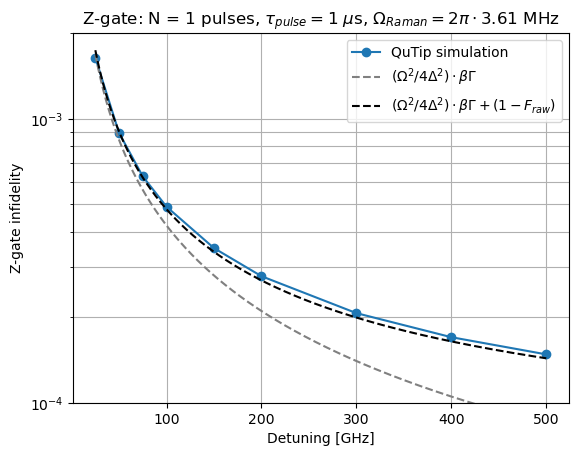

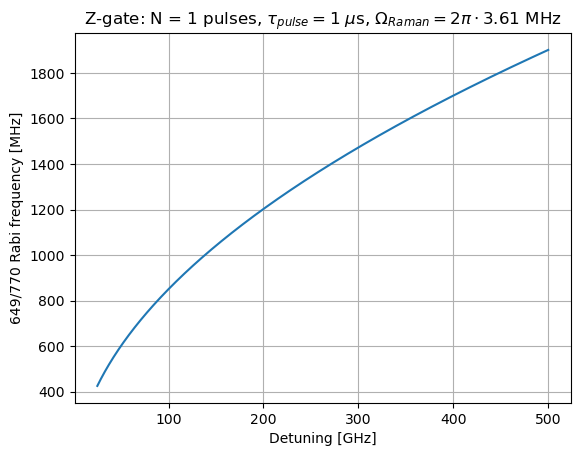

In [299]:
detunings = 2 * np.pi * np.array([25, 50, 75, 100, 150, 200, 300, 400, 500]) * 1e9
infidelities_1_pulse = [
    0.0016387905997842234,
    0.0008901565251490107,
    0.0006258597259006793,
    0.0004895795218495813,
    0.00035013100890457505,
    0.0002788542571656727,
    0.00020672115016540094,
    0.00017008561143627698,
    0.00014797046517767143
]

Gamma = 2 * np.pi * 10.01 * 1e6

Delta_xs = np.linspace(detunings[0], detunings[-1], 1000)
Omega_649s = np.sqrt(Omega_Raman * (2 * Delta_xs))
scattering_errors = 0.37 * Omega_649s**2 / (4 * Delta_xs**2) * Gamma * 1e-6
no_scattering_infidelity = 2.0530926270190264e-06

plt.figure()
plt.plot(detunings / 1e9 / 2 / np.pi, infidelities, 'o-', label='QuTip simulation')
plt.plot(Delta_xs / 1e9 / 2 / np.pi, scattering_errors,
         '--', color='grey', label=r'$(\Omega^2 / 4\Delta^2) \cdot \beta \Gamma$')
plt.plot(Delta_xs / 1e9 / 2 / np.pi, scattering_errors + no_scattering_infidelity,
         '--', color='black', label=r'$(\Omega^2 / 4\Delta^2) \cdot \beta \Gamma + (1 - F_{raw})$')
plt.xlabel('Detuning [GHz]')
plt.ylabel('Z-gate infidelity')
plt.yscale('log')
plt.ylim(1e-4, 2e-3)
plt.grid(which='both')
plt.legend()
plt.title('Z-gate: N = 1 pulses, $\\tau_{pulse} = 1$ $\mu $s, $\Omega_{Raman} = 2\pi\cdot 3.61$ MHz')

plt.figure()
plt.title('Z-gate: N = 1 pulses, $\\tau_{pulse} = 1$ $\mu $s, $\Omega_{Raman} = 2\pi\cdot 3.61$ MHz')
plt.plot(Delta_xs / 2 / np.pi / 1e9, Omega_649s / 2 / np.pi / 1e6)
plt.xlabel('Detuning [GHz]')
plt.ylabel('649/770 Rabi frequency [MHz]')
plt.grid()

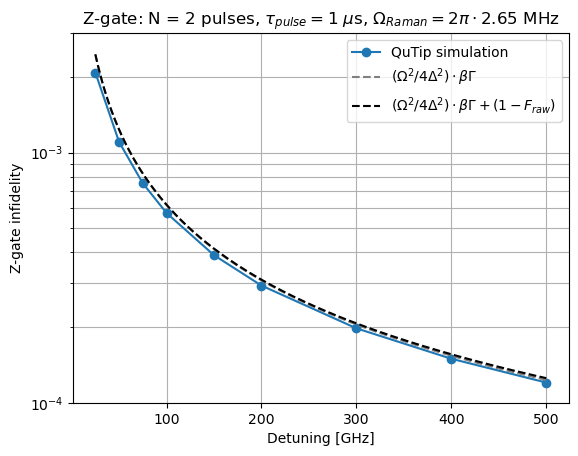

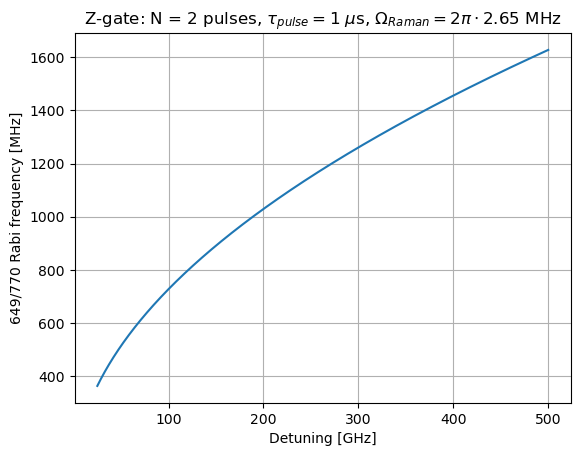

In [310]:
detunings = 2 * np.pi * np.array([25, 50, 75, 100, 150, 200, 300, 400, 500]) * 1e9
infidelities_2_pulse = [
    0.00208684551727345,
    0.0011020595573340008,
    0.0007531676114661545,
    0.0005730228999508702,
    0.00038868433171279637,
    0.00029390820226160574,
    0.00019832022951737915,
    0.0001498714203830298,
    0.0001203797937766593
]
Gamma = 2 * np.pi * 10.01 * 1e6

Delta_xs = np.linspace(detunings[0], detunings[-1], 1000)
Omega_649s = np.sqrt(Omega_Raman * (2 * Delta_xs))
scattering_errors = 0.37 * Omega_649s**2 / (4 * Delta_xs**2) * Gamma * 2e-6
no_scattering_infidelity = 2.0530926270190264e-06

plt.figure()
plt.plot(detunings / 1e9 / 2 / np.pi, infidelities_2_pulse, 'o-', label='QuTip simulation')
plt.plot(Delta_xs / 1e9 / 2 / np.pi, scattering_errors,
         '--', color='grey', label=r'$(\Omega^2 / 4\Delta^2) \cdot \beta \Gamma$')
plt.plot(Delta_xs / 1e9 / 2 / np.pi, scattering_errors + no_scattering_infidelity,
         '--', color='black', label=r'$(\Omega^2 / 4\Delta^2) \cdot \beta \Gamma + (1 - F_{raw})$')
plt.xlabel('Detuning [GHz]')
plt.ylabel('Z-gate infidelity')
plt.yscale('log')
plt.ylim(1e-4, 3e-3)
plt.grid(which='both')
plt.legend()
plt.title('Z-gate: N = 2 pulses, $\\tau_{pulse} = 1$ $\mu $s, $\Omega_{Raman} = 2\pi\cdot 2.65$ MHz')

plt.figure()
plt.title('Z-gate: N = 2 pulses, $\\tau_{pulse} = 1$ $\mu $s, $\Omega_{Raman} = 2\pi\cdot 2.65$ MHz')
plt.plot(Delta_xs / 2 / np.pi / 1e9, Omega_649s / 2 / np.pi / 1e6)
plt.xlabel('Detuning [GHz]')
plt.ylabel('649/770 Rabi frequency [MHz]')
plt.grid()

In [317]:
data = {
    'Omega_Raman': Omega_Raman,
    'Delta': Deltas,
    'rise_sigma': rise_sigma,
    'outputs': outputs
}

with open('data/20250206_two_pulse_infidelity.pkl', 'wb') as f:
    pickle.dump(data, f)

In [ ]:
def gaussian_flat_top(t, t0, tau, rise_time, k=3):
    sigma = rise_time / k
    flat_time = tau - 2 * rise_time
    
    # Compute sections with vectorized operations
    a = np.exp(-0.5 * ((-rise_time) / sigma) ** 2)
    ring_up = (np.exp(-0.5 * (((t - t0) - rise_time) / sigma) ** 2) - a) / (1 - a)
    ring_down = (np.exp(-0.5 * ((rise_time + flat_time - (t - t0)) / sigma) ** 2) - a) / (1 - a)

    # Create a mask for different regions
    ring_up_mask = (t0 <= t) & (t <= t0 + rise_time)
    flat_mask = (t > t0 + rise_time) & (t < t0 + rise_time + flat_time)
    ring_down_mask = (t >= t0 + rise_time + flat_time) & (t <= t0 + tau)

    # Initialize output array
    result = np.zeros_like(t)

    # Assign values based on masks
    result[ring_up_mask] = ring_up[ring_up_mask]
    result[flat_mask] = 1
    result[ring_down_mask] = ring_down[ring_down_mask]

    return result


num_points = 1000
rise_time = 0.5
gate_time = 1
num_pulses = 5
ts = np.linspace(0, num_pulses * gate_time, num_points)
pulse = np.zeros_like(ts)
for i in range(num_pulses):
    pulse += gaussian_flat_top(ts, ts[i * num_points // num_pulses], gate_time, rise_time, k=4)
    
plt.figure()

plt.plot(ts, pulse)

In [3]:
def simulate_scattering_rate(
    Omega_649: float,
    Omega_770: float,
    detuning: float,
    gate_time: float,
    num_points: int,
    initial_states: list[str],
    detuning_offset: float = 0,
):
    
    
    freq_scale = 1e9  # GHz
    
    # =========================
    # Initialize energy levels 
    # =========================
    # NOTE: hard-coded for 5G magnetic field
    
    levels = [
        # 3P0 sublevels
        {'level': '3P0', 'J': 0, 'F': 1/2, 'mF': 1/2,  'energy_Hz': 0},
        {'level': '3P0', 'J': 0, 'F': 1/2, 'mF': -1/2, 'energy_Hz': 3749.528976851414},
        # 3S1 sublevels
        {'level': '3S1', 'J': 1, 'F': 1/2, 'mF': 1/2,  'energy_Hz': 461850274160685.7},
        {'level': '3S1', 'J': 1, 'F': 1/2, 'mF': -1/2, 'energy_Hz': 461850292913971.44},
        {'level': '3S1', 'J': 1, 'F': 3/2, 'mF': 3/2,  'energy_Hz': 461860484233885.6},
        {'level': '3S1', 'J': 1, 'F': 3/2, 'mF': 1/2,  'energy_Hz': 461860493612403.4},
        {'level': '3S1', 'J': 1, 'F': 3/2, 'mF': -1/2, 'energy_Hz': 461860502990920.8},
        {'level': '3S1', 'J': 1, 'F': 3/2, 'mF': -3/2, 'energy_Hz': 461860512369438.56},
        # 3P2 sublevels
        {'level': '3P2', 'J': 2, 'F': 3/2, 'mF': 3/2,  'energy_Hz': 72602523903671.75},
        {'level': '3P2', 'J': 2, 'F': 3/2, 'mF': 1/2,  'energy_Hz': 72602536499251.66},
        {'level': '3P2', 'J': 2, 'F': 3/2, 'mF': -1/2, 'energy_Hz': 72602549094831.69},
        {'level': '3P2', 'J': 2, 'F': 3/2, 'mF': -3/2, 'energy_Hz': 72602561690411.6},
        {'level': '3P2', 'J': 2, 'F': 5/2, 'mF': 5/2,  'energy_Hz': 72609214146883.69},
        {'level': '3P2', 'J': 2, 'F': 5/2, 'mF': 3/2,  'energy_Hz': 72609222545186.78},
        {'level': '3P2', 'J': 2, 'F': 5/2, 'mF': 1/2,  'energy_Hz': 72609230943489.86},
        {'level': '3P2', 'J': 2, 'F': 5/2, 'mF': -1/2, 'energy_Hz': 72609239341793.05},
        {'level': '3P2', 'J': 2, 'F': 5/2, 'mF': -3/2, 'energy_Hz': 72609247740096.14},
        {'level': '3P2', 'J': 2, 'F': 5/2, 'mF': -5/2, 'energy_Hz': 72609256138399.22},
    ]

    N = len(levels) + 1  # include extra state to model 3S1 -> 3P1 decay
    basis_states = []
    for i, level in enumerate(levels):
        new_row = level.copy()
        new_row['basis'] = basis(N, i)
        basis_states.append(new_row)
    basis_states = pd.DataFrame(basis_states)
    
    # set intermediate and excited states for Raman gate
    reference_state_3s1 = basis_states[(basis_states['level'] == '3S1') & \
                                       (basis_states['F'] == 3/2) & \
                                       (basis_states['mF'] == 1/2)]
    reference_state_3p2 = basis_states[(basis_states['level'] == '3P2') & \
                                       (basis_states['F'] == 5/2) & \
                                       (basis_states['mF'] == 1/2)]
        
    # ==============================
    # matrix elements [atomic units]
    # ==============================
    
    # level1 = 3P0 -> level2 = 3S1
    matrix_elements_649 = [
        {'F1': 1/2, 'F2': 1/2, 'mF1': 1/2, 'mF2': 1/2, 'matrix_element': 0.660000},
        {'F1': 1/2, 'F2': 1/2, 'mF1': -1/2, 'mF2': -1/2, 'matrix_element': -0.660000},
        {'F1': 1/2, 'F2': 3/2, 'mF1': 1/2, 'mF2': 1/2, 'matrix_element': -0.933381},
        {'F1': 1/2, 'F2': 3/2, 'mF1': -1/2, 'mF2': -1/2, 'matrix_element': -0.933381},
    ]
    # level1 = 3P2 -> level2 = 3S1 
    matrix_elements_770 = [
        {'F1': 3/2, 'F2': 1/2, 'mF1': 1/2, 'mF2': 1/2, 'matrix_element': 1.683333},
        {'F1': 3/2, 'F2': 1/2, 'mF1': -1/2, 'mF2': -1/2, 'matrix_element': 1.683333},
        {'F1': 3/2, 'F2': 3/2, 'mF1': 3/2, 'mF2': 3/2, 'matrix_element': -0.714178},
        {'F1': 3/2, 'F2': 3/2, 'mF1': 1/2, 'mF2': 1/2, 'matrix_element': -0.238059},
        {'F1': 3/2, 'F2': 3/2, 'mF1': -1/2, 'mF2': -1/2, 'matrix_element': 0.238059},
        {'F1': 3/2, 'F2': 3/2, 'mF1': -3/2, 'mF2': -3/2, 'matrix_element': 0.714178},
        {'F1': 5/2, 'F2': 3/2, 'mF1': 3/2, 'mF2': 3/2, 'matrix_element': 1.428356},
        {'F1': 5/2, 'F2': 3/2, 'mF1': 1/2, 'mF2': 1/2, 'matrix_element': 1.749371},
        {'F1': 5/2, 'F2': 3/2, 'mF1': -1/2, 'mF2': -1/2, 'matrix_element': 1.749371},
        {'F1': 5/2, 'F2': 3/2, 'mF1': -3/2, 'mF2': -3/2, 'matrix_element': 1.428356},
    ]
    
    reference_matrix_element_649 = -0.933381
    reference_matrix_element_770 = 1.749371
    # compute Rabi frequencies [Hz] for each transition
    rabi_frequencies_649 = []
    for row in matrix_elements_649:
        # copy row and remove matrix element
        new_row = row.copy()
        new_row.pop('matrix_element')
        # compute rabi frequency
        matrix_element = row['matrix_element']
        new_row['rabi_frequency'] = Omega_649 * matrix_element / reference_matrix_element_649
        rabi_frequencies_649.append(new_row)
    # compute Rabi frequencies [Hz] for each transition
    rabi_frequencies_770 = []
    for row in matrix_elements_770:
        # copy row and remove matrix element
        new_row = row.copy()
        new_row.pop('matrix_element')
        # compute rabi frequency
        matrix_element = row['matrix_element']
        new_row['rabi_frequency'] = Omega_770 * matrix_element / reference_matrix_element_770
        rabi_frequencies_770.append(new_row)
        
    # =====================
    # Construct Hamiltonian
    # =====================
    
    # Initialize Hamiltonian
    H0 = 0

    # 3P0 -> 3S1
    for transition in rabi_frequencies_649:
        Omega = transition['rabi_frequency'] / freq_scale
        state1 = basis_states[(basis_states['level'] == '3P0') & \
                            (basis_states['F'] == transition['F1']) & \
                            (basis_states['mF'] == transition['mF1'])]
        state2 = basis_states[(basis_states['level'] == '3S1') & \
                            (basis_states['F'] == transition['F2']) & \
                            (basis_states['mF'] == transition['mF2'])]
        # add coupling term
        basis1 = state1['basis'].values[0]
        basis2 = state2['basis'].values[0]
        coupling_term = (Omega / 2) * (basis1 * basis2.dag() + basis2 * basis1.dag())
        H0 += coupling_term
        
    # 3S1 -> 3P2
    for transition in rabi_frequencies_770:
        Omega = transition['rabi_frequency'] / freq_scale
        state1 = basis_states[(basis_states['level'] == '3P2') & \
                            (basis_states['F'] == transition['F1']) & \
                            (basis_states['mF'] == transition['mF1'])]
        state2 = basis_states[(basis_states['level'] == '3S1') & \
                            (basis_states['F'] == transition['F2']) & \
                            (basis_states['mF'] == transition['mF2'])]
        # add coupling term
        basis1 = state1['basis'].values[0]
        basis2 = state2['basis'].values[0]
        coupling_term = (Omega / 2) * (basis1 * basis2.dag() + basis2 * basis1.dag())
        H0 += coupling_term
        
    # add detunings
    for state in basis_states.to_records():
        if state['level'] in ['3P0', '3P2']:
            H0 += (detuning / freq_scale) * state['basis'] * state['basis'].dag()
        if state['level'] == '3S1':
            ref_detuning = (state['energy_Hz'] - reference_state_3s1['energy_Hz'].values[0]) / freq_scale
            H0 += 2 * np.pi * ref_detuning * state['basis'] * state['basis'].dag()
        if state['level'] == '3P2':
            ref_detuning = (state['energy_Hz'] - reference_state_3p2['energy_Hz'].values[0]) / freq_scale
            H0 += 2 * np.pi * ref_detuning * state['basis'] * state['basis'].dag()
            # detune 770 halfway between mF = -1/2 and mF = 1/2 sublevels
            H0 -= 2 * np.pi * 4.19915159375 * 1e6 / freq_scale * state['basis'] * state['basis'].dag()
            # add constant detuning offset
            H0 += (detuning_offset / freq_scale) * state['basis'] * state['basis'].dag()
    
    # Time vector
    t_max = gate_time * freq_scale    
    t_list = np.linspace(0, t_max, num_points)
        
    # ============================
    # Construct collapse operators
    # ============================
    
    I = 1/2
    levels_3s1 = basis_states[(basis_states['level'] == '3S1')].to_records()
    levels_3p2 = basis_states[(basis_states['level'] == '3P2')].to_records()
    levels_3p0 = basis_states[(basis_states['level'] == '3P0')].to_records()
    basis_3p1 = basis(N, N-1)
    decay_rate_3s1 = 2 * np.pi * 10.01 * 1e6 / freq_scale
    branching_ratios = {'3P2': 0.5, '3P1': 0.37, '3P0': 0.13}
    
    def calculate_c_op(level_g, level_e):
        F_e = level_e['F']
        F_g = level_g['F']
        mF_e = level_e['mF']
        mF_g = level_g['mF']
        J_e = level_e['J']
        J_g = level_g['J']
        basis_e = level_e['basis']
        basis_g = level_g['basis']
        return (-1)**(F_e + J_g + 1 + I) * \
                np.sqrt((2 * F_e + 1) * (2 * J_g + 1)) * \
                CG(F_e, mF_e, 1, q, F_g, mF_g).doit() * \
                float(wigner_6j(J_e, J_g, 1, F_g, F_e, I)) * \
                basis_g * basis_e.dag()
    
    c_ops_3p2 = []
    c_ops_3p0 = []
    for q in [-1, 0, 1]:
        c_op_3p2 = 0
        c_op_3p0 = 0
        for level_3s1 in levels_3s1:
            for level_3p2 in levels_3p2:
                c_op_3p2 += calculate_c_op(level_3p2, level_3s1)
            for level_3p0 in levels_3p0:
                c_op_3p0 += calculate_c_op(level_3p0, level_3s1)
        c_op_3p2 *= np.sqrt(decay_rate_3s1 * branching_ratios['3P2'])
        c_op_3p0 *= np.sqrt(decay_rate_3s1 * branching_ratios['3P0'])
        c_ops_3p2.append(c_op_3p2)
        c_ops_3p0.append(c_op_3p0)
    # add 3P1
    c_op_3p1 = 0
    for level_3s1 in levels_3s1:
        c_op_3p1 += basis_3p1 * level_3s1['basis'].dag() 
    c_op_3p1 *= np.sqrt(decay_rate_3s1 * branching_ratios['3P1'])
        
    c_ops = c_ops_3p0 + c_ops_3p2 + [c_op_3p1]
    
    # =======================
    # Simulate time evolution
    # =======================
    
    qubit_basis_0 = basis_states[(basis_states['level'] == '3P0') & \
                                 (basis_states['F'] == 1/2) & \
                                 (basis_states['mF'] == -1/2)]['basis'].values[0]
    qubit_basis_1 = basis_states[(basis_states['level'] == '3P0') & \
                                 (basis_states['F'] == 1/2) & \
                                 (basis_states['mF'] == 1/2)]['basis'].values[0]

    rho_inital_dict = {
        '00': qubit_basis_0 * qubit_basis_0.dag(), 
        '01': qubit_basis_0 * qubit_basis_1.dag(), 
        '10': qubit_basis_1 * qubit_basis_0.dag(), 
        '11': qubit_basis_1 * qubit_basis_1.dag()
    }

    # Expectation operators
    e_ops = [state['basis'] * state['basis'].dag() for state in basis_states.to_records()]

    # Solve for the time evolution
    result_dict = {}
    for state in initial_states:
        result = mesolve(
            H0,
            rho_inital_dict[state], 
            t_list, 
            e_ops=e_ops, 
            c_ops=c_ops,
            options=dict(store_states=True))
        result_dict[state] = result
        
    # Construct return value
    output = {
        'basis_states': basis_states,
        't_list': t_list,
        'results': result_dict
    }
        
    return output

In [6]:
Omega_649s = 2 * np.pi * np.array([200, 400, 600]) * 1e6
Omega_770 = 0
detunings = 2 * np.pi * np.array([25, 50, 75, 100, 150, 200, 250]) * 1e9
gate_time = 1 * 1e-6
initial_states = ['00', '11']
detuning_offset = 0

outputs = []
for Omega_649 in Omega_649s:
    temp = []
    for detuning in detunings:
        if detuning/2/np.pi/1e9 > 75:
            num_points = 3000
        else:
            num_points = 1000
        output = simulate_scattering_rate(
            Omega_649 = Omega_649,
            Omega_770 = Omega_770,
            detuning = detuning,
            gate_time = gate_time,
            num_points = num_points,
            initial_states = initial_states,
            detuning_offset = detuning_offset
        )
        temp.append(output)
    outputs.append(temp)

IntegratorException: Excess work done on this call. Try to increasing the nsteps parameter in the Options class

Text(0.5, 0, 'Time [ns]')

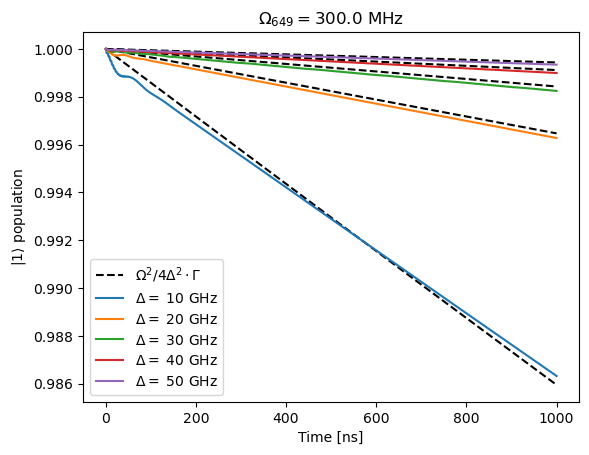

In [73]:
%matplotlib inline

plt.figure()

for i, (output, detuning) in enumerate(zip(outputs, detunings)):
    
    basis_states = output['basis_states']
    results = output['results']
    ts = output['t_list']
    ground_1_idx = [i for i, state in enumerate(basis_states.to_records()) \
        if state['level'] == '3P0' and state['F'] == 0.5 and state['mF'] == 0.5][0]

    Gamma = 2 * np.pi * 10.01 * 1e6
    beta = 1
    scattering_rate = beta * (Omega_649**2 / (4 * detuning**2)) * Gamma / freq_scale
    
    label = r'$\Omega^2 / 4 \Delta^2 \cdot \Gamma$' if i == 0 else None
    plt.plot(ts, np.exp(-ts * scattering_rate), color='black', linestyle='--', label=label)
    plt.plot(ts, results['11'].expect[ground_1_idx], label=r'$\Delta =$' + f'{detuning / freq_scale / 2 / np.pi : .0f} GHz')

plt.legend()
plt.title(r'$\Omega_{649} = $' + f'{Omega_649 / 1e6 / 2 / np.pi} MHz')
plt.ylabel(r'$|1\rangle$ population')
plt.xlabel('Time [ns]')

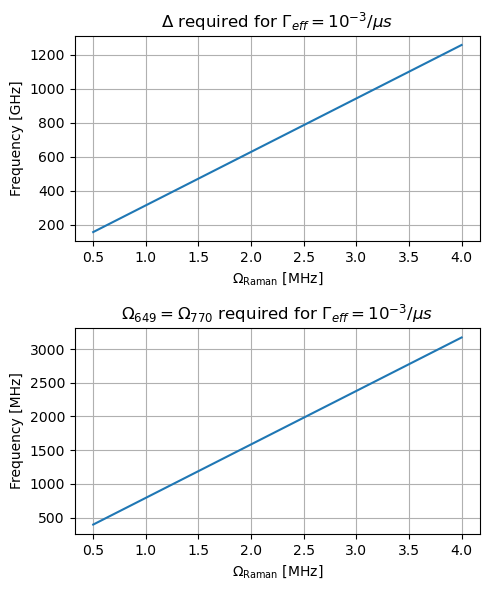

In [201]:
Gamma = 2 * np.pi * 10.01
Omega_Ramans = 2 * np.pi * np.linspace(0.5, 4, 50)
gate_time = 1
target_leakage = 1e-4
detunings = Omega_Ramans * Gamma * gate_time / 2 / target_leakage
Omegas = np.sqrt(Omega_Ramans * 2 * detunings)

fig, ax = plt.subplots(nrows=2, figsize=(5,6))
ax[0].set_title("$\Delta$ required for $\Gamma_{eff} = 10^{-3}/\mu s$")
ax[1].set_title("$\Omega_{649} = \Omega_{770}$ required for $\Gamma_{eff} = 10^{-3}/\mu s$")
ax[0].plot(Omega_Ramans / 2 / np.pi, detunings / 2 / np.pi / 1e3)
ax[1].plot(Omega_Ramans / 2 / np.pi, Omegas / 2 / np.pi)
ax[0].set_xlabel(r'$\Omega_\text{Raman}$ [MHz]')
ax[1].set_xlabel(r'$\Omega_\text{Raman}$ [MHz]')
ax[0].set_ylabel('Frequency [GHz]')
ax[1].set_ylabel('Frequency [MHz]')
ax[0].grid()
ax[1].grid()
fig.tight_layout()

In [314]:
def calculate_required_power(rabi_freq, matrix_element, beam_waist):

    dipole_moment_si = constants.physical_constants['Bohr radius'][0] * constants.e
    E_field = rabi_freq * constants.hbar / (np.abs(matrix_element) * dipole_moment_si)
    intensity = E_field**2 * constants.epsilon_0 * constants.c / 2
    power = intensity * np.pi * beam_waist**2 / 2
    return power

rabi_freq = 2 * np.pi * 700 * 1e6
beam_waist = 500 * 1e-6
matrix_element_649 = -0.933381
matrix_element_770 = 1.749371
# calculate_required_power(rabi_freq, matrix_element_649, beam_waist) * 1e3
calculate_required_power(rabi_freq, matrix_element_770, beam_waist) * 1e3

326.21245358356305

In [316]:
700 * 400 / (2 * 300 * 1e3)

0.4666666666666667

Text(0, 0.5, '$\\Omega_\\text{Raman}$ [MHz]')

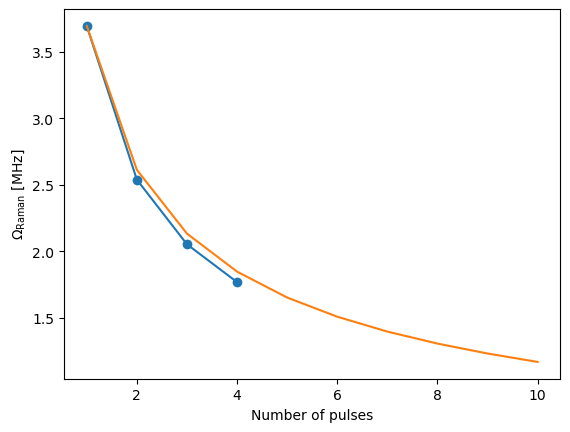

In [199]:
import pickle
with open('data/20250204_rise_time_vs_infidelity_sweep.pkl', 'rb') as f:
    data = pickle.load(f)
    
# num_pulses_arr = data['num_pulses']
# optimal_infidelities_arr = data['optimal_infidelities']
# idxs = np.argmin(optimal_infidelities_arr, axis=1)
# optimal_Omegas = [data['optimal_Omegas'][i][idx] / 2 / np.pi for i, idx in enumerate(idxs)]

num_pulses_arr = data['num_pulses']
optimal_infidelities_arr = data['optimal_infidelities']
optimal_Omegas = [data['optimal_Omegas'][i][4] / 2 / np.pi for i in range(4)]

xs = np.linspace(1, 10, 10)

plt.figure()
plt.plot(num_pulses_arr, optimal_Omegas, 'o-')
plt.plot(xs, optimal_Omegas[0] / np.sqrt(xs))
plt.xlabel('Number of pulses')
plt.ylabel(r'$\Omega_\text{Raman}$ [MHz]')

In [7]:
import scipy.constants as constants
import numpy as np

constants.hbar * 2 * np.pi * 100e6 / constants.Boltzmann / 1e-3

4.799243073366221

In [1]:
from pybkit.amo.atom import Yb171

yb = Yb171(B_field=5e-4)

In [9]:
level1 = yb.get_hyperfine_level('6s7s 3S1 F=1.5 mF=1.5')
level2 = yb.get_hyperfine_level('6s7s 3S1 F=1.5 mF=0.5')

transition = yb.get_transition(level1, level2)
transition.calculate_frequency(unit='MHz')

-9.378517642011678

In [17]:
level1 = yb.get_hyperfine_level('6s6p 3P2 F=2.5 mF=1.5')
level2 = yb.get_hyperfine_level('6s6p 3P2 F=2.5 mF=0.5')

transition = yb.get_transition(level1, level2)
transition.calculate_frequency(unit='MHz')

-8.398303082142839

In [19]:
import numpy as np

In [22]:
(1/np.sqrt(5))**2/((5*8.4)**2) / 1e-4

1.1337868480725621